# Forest damage identification model

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy
import pandas
import rasterio
from rasterio.mask import mask
import glob
import pyproj
from pyproj import Transformer
from shapely.ops import transform as sh_transform
import numpy
import torch
import torch.nn as nn
import pickle
import cv2
from PIL import Image
import timm
import shapely.geometry
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

Due to storage limitations the data extraction was done previous to notebook upload.  The inital data was downloaded from https://earthexplorer.usgs.gov/.  In future iterations STAC can be used to automatically download the target data, see STAC_Data notebook for intial desgin.  This geospatial extracted data is found in the processed directory. 

In [ ]:
#read layer of target date, https://www.fs.fed.us/foresthealth/applied-sciences/mapping-reporting/detection-surveys.shtml
#download and save bands to local: https://earthexplorer.usgs.gov/
#should pivot to using stac catalog in .tar to ensure sorting is correct
#You should grab B1-B7.tiffs but due to the extenadlable nature of the model any bands will do assuming 
#they are ordered consitentaly. 
geoDF = gpd.read_file('CONUS_Region5_2020.gdb', layer=0)
with open('USFS_data.geojson', 'w') as f:
    f.write(geoDF.to_json())


#bbox = [ -120.4720, 38.5159, -120.1238, 38.7707] #larger area
bbox = [ -120.2577, 38.6383, -120.2975, 38.6684]
bbox_poly = shapely.geometry.box(*bbox, ccw=True)
#bbox_poly = bbox_poly.buffer(0.01)
files = glob.glob('image_bands/*')

for i in range(0, len(files), 1):
    file_bands = glob.glob(f'{files[i]}\*')
    file_bands = sorted(file_bands, reverse=False)

    #See https://github.com/marvingabler/cog_how_to for examples of how to extract a bbox.
    #We open the first band and obtain the correct metadata for our region of intrest.
    with rasterio.open(file_bands[0]) as geo_fp:
        #set up transformer to reproject bbox to image crs. 
        transformer_poly = Transformer.from_crs("epsg:4326", geo_fp.crs)
        profile = geo_fp.profile.copy()
        project = pyproj.Transformer.from_crs(4326, geo_fp.crs, always_xy=True).transform
        bbox_projected = sh_transform(project, bbox_poly)
        coord_upperleft = transformer_poly.transform(bbox[3], bbox[0])
        coord_lowerright = transformer_poly.transform(bbox[1], bbox[2])
        out, t = rasterio.mask.mask(geo_fp, [bbox_projected], crop=True, invert=False)
        #update metadata with correct shape which has changed due to masking
        height, width = out[0].shape
        profile["width"] = width
        profile["height"] = height
        new_transform = rasterio.Affine(profile["transform"][0], profile["transform"][1], coord_upperleft[0], profile["transform"][3], profile["transform"][4], coord_upperleft[1])
        profile["transform"] = new_transform
    profile.update(count=len(file_bands))
    #We then apply this created metadata and make a stacked tiff. 
    with rasterio.open(f'processed/stack_bbox_{i}.tif', "w", **profile) as dst:
        for id_band, link in enumerate(file_bands, start=1):
            with rasterio.open(link) as geo_fp_sub:
                out, _ = rasterio.mask.mask(geo_fp_sub, [bbox_poly_project], crop=True, invert=False)
                if numpy.all(out == 0):
                    print("bad:", files[i])
                dst.write_band(id_band, out[0])

This section of code creates the test and training masking datasets using the USFS tree servery data. 

(8, 116, 120) 7740.040445402299 1
(8, 116, 120) 10931.749281609196 2
(8, 116, 120) 7719.250574712643 3
(8, 116, 120) 14959.931752873563 4
(8, 116, 120) 7981.786422413793 5
(8, 116, 120) 12920.193390804598 6
(8, 116, 120) 7738.546048850575 7


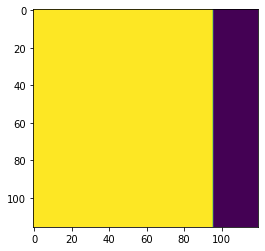

In [4]:
#data chipping
files = glob.glob('processed/*')

#This loads all the images and creases a stacked array
for id_band, image in enumerate(files, start=1):
    with rasterio.open(image) as geo_fp_sub:
        subset = geo_fp_sub.read()
        profile = geo_fp_sub.profile.copy()
        print(subset.shape, subset[2].mean(), id_band)
        if id_band == 1:
            out_stacked = subset
        else:
            out_stacked = numpy.concatenate((out_stacked, subset), axis = 0)


#This takes that stacked array and saves it
profile.update(count=8*len(files))

with rasterio.open('processed_full/stack_bbox_stacked_fixed.tif', "w", **profile) as dst:
            dst.write(out_stacked)
        
#We then load the USFS data into a geopandas data frame.  
 
data = gpd.read_file('USFS_data.geojson')
data = data.to_crs(profile.data['crs'])

#This loop looks at the PERCENT_AFFECTED_CODE which ranges from 1 to 3 and creates a mask that is populated with
#either 0 for no data, or the percent affected code. 
for code in range(1, 3, 1):
    data_tm = data.loc[data['PERCENT_AFFECTED_CODE'] == code]
    with rasterio.open('processed_full/stack_bbox_stacked_fixed.tif') as geo_fp:
        out, _ = rasterio.mask.mask(geo_fp, data_tm.geometry, crop=False, invert=False)
        out[out > 0] = code
    if code == 1:
        out_masked = out[0]
    else:
        out_masked = out_masked + out[0]
##########################################

#This section of code created a split_num (in this case 80%) that devides the dataset into 80/20 for testing and training. 
#This test/train is saved as a mask as its own band
plt.imshow(out_masked)
split = numpy.zeros(out_masked.shape)
split_num = 0.8
split[:,0:int(out_masked.shape[1]*split_num)] = 1
plt.imshow(split)

#Finally combine the masks and data into one array.
out_stacked_final = numpy.vstack((split.reshape(1,out_stacked.shape[1],out_stacked.shape[2]),
                                  out_masked.reshape(1,out_stacked.shape[1],out_stacked.shape[2]), out_stacked ))

profile['count'] = profile['count']+2
with rasterio.open('processed_full/final_data.tif', "w", **profile) as dst:
    dst.write(out_stacked_final)


This section creates the ImageNet feature resepentations for classification.

In [5]:
model = timm.create_model('hrnet_w18_small', pretrained=True)
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])
model.eval()
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

#toda: add scrambelled parameter
random = False

data = out_stacked_final[2:,:,:]

def feature_creation(data, random = False, show = False):
    final_imagenet = numpy.zeros((2048,  data.shape[1],  data.shape[2]))
    for ii in range(0, data.shape[1], 1):
        print(ii / data.shape[1])
        for iii in range(0, data.shape[2], 1):
            pixel = data[:, ii, iii]
            if random == True:
                numpy.random.shuffle(pixel)
            pixel = pixel.reshape(int(pixel.shape[0]/8), 8)
            pixel_out = numpy.zeros((3, pixel.shape[0], pixel.shape[1]))
            pixel_out[0,:,:] = pixel/3
            pixel_out[1,:,:] = pixel/3
            pixel_out[2,:,:] = pixel/3
            norm_image = cv2.normalize(pixel_out, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            norm_image = norm_image.astype(numpy.uint8)
            PIL_image = Image.fromarray(norm_image.T, 'RGB')
            if show == True:
                plt.imshow(pixel)
                size = 256, 256
                im = PIL_image.resize(size, Image.ANTIALIAS)
                im.show()
            tensor = transform(PIL_image).unsqueeze(0)  # transform and add batch dimension
            with torch.no_grad():
                out = model(tensor)
            results = out.detach().numpy()
            final_imagenet[:, ii , iii] = results
    return final_imagenet


imagenet_features = feature_creation(data, random = False, show = False)
out_stacked_features_full = numpy.vstack((out_stacked_final[0:2,:,:], imagenet_features))
numpy.save("small_hr_labled.npy", out_stacked_features_full)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


0.0
0.008620689655172414
0.017241379310344827
0.02586206896551724
0.034482758620689655
0.04310344827586207
0.05172413793103448
0.0603448275862069
0.06896551724137931
0.07758620689655173
0.08620689655172414
0.09482758620689655
0.10344827586206896
0.11206896551724138
0.1206896551724138
0.12931034482758622
0.13793103448275862
0.14655172413793102
0.15517241379310345
0.16379310344827586
0.1724137931034483
0.1810344827586207
0.1896551724137931
0.19827586206896552
0.20689655172413793
0.21551724137931033
0.22413793103448276
0.23275862068965517
0.2413793103448276
0.25
0.25862068965517243
0.2672413793103448
0.27586206896551724
0.28448275862068967
0.29310344827586204
0.3017241379310345
0.3103448275862069
0.31896551724137934
0.3275862068965517
0.33620689655172414
0.3448275862068966
0.35344827586206895
0.3620689655172414
0.3706896551724138
0.3793103448275862
0.3879310344827586
0.39655172413793105
0.4051724137931034
0.41379310344827586
0.4224137931034483
0.43103448275862066
0.4396551724137931
0.4482

This section creates the classifcation of the pixel using a basic regesstion with partial fit to allow for using smaller slices of the dataset.  

In [6]:
def model(out_stacked_features_full):
    import pandas
    import numpy
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import datasets, ensemble, linear_model
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.model_selection import train_test_split
    reg = linear_model.SGDRegressor()
    mse = []
    r2 = []
    for batch in range(0, 10, 1):
        try:
            # since we have a large image we slice the data down a bit, this tiling can be shifted around and an ensemblemodel created
            batch_size = int(out_stacked_features_full.shape[1] * 0.1)
            out_stacked_features = out_stacked_features_full[:, int(batch * batch_size):int((batch + 1) * batch_size), :]

            X_train = numpy.zeros(
                (out_stacked_features.shape[1] * out_stacked_features.shape[2], out_stacked_features.shape[0] - 2))
            y_train = numpy.zeros((out_stacked_features.shape[1] * out_stacked_features.shape[2]))

            X_test = numpy.zeros(
                (out_stacked_features.shape[1] * out_stacked_features.shape[2], out_stacked_features.shape[0] - 2))
            y_test = numpy.zeros((out_stacked_features.shape[1] * out_stacked_features.shape[2]))

            test_counter = 0
            train_counter = 0
            for i in range(0, out_stacked_features.shape[1], 1):
                for ii in range(0, out_stacked_features.shape[2], 1):
                    if out_stacked_features[0, i, ii] == 1:
                        X_train[train_counter, :] = out_stacked_features[2:, i, ii].copy()
                        y_train[train_counter] = out_stacked_features[1, i, ii]
                        train_counter += 1
                    elif out_stacked_features[0, i, ii] == 0:
                        X_test[test_counter, :] = out_stacked_features[2:, i, ii].copy()
                        y_test[test_counter] = out_stacked_features[1, i, ii]
                        test_counter += 1
                    else:
                        continue
                        #print("hit outside bound")


            X_train = X_train[0:train_counter, :]
            y_train = y_train[0:train_counter]
            X_test = X_test[0:test_counter, :]
            y_test = y_test[0:test_counter]

            #reg = ensemble.GradientBoostingRegressor(**params)
            reg.partial_fit(X_train, y_train)
            mse.append(mean_squared_error(y_test, reg.predict(X_test)))
            r2.append(r2_score(y_test, reg.predict(X_test)))
        except:
            print("batch failed")

    return reg, mse, r2



model_1, mse, r2 = model(out_stacked_features_full)

# save
with open('model_hrnet_small.pkl','wb') as f:
    pickle.dump(model_1,f)

Infeance on the holdout set and assoaciated vizualizations. 

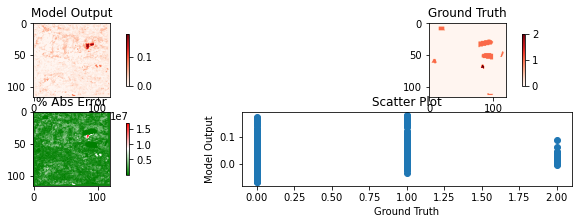

In [7]:
#########viz
out_viz = numpy.zeros((1, out_stacked_features_full.shape[1], out_stacked_features_full.shape[2]))
for i in range(0, out_stacked_features_full.shape[1], 1):
    for ii in range(0, out_stacked_features_full.shape[2], 1):
        out_viz[0, i, ii] = model_1.predict(out_stacked_features_full[2:,i,ii].reshape(1, -1))

from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('gr',["g", "w", "r"], N=100)


#out_viz_segment = np.where(out_viz[0] > out_viz[0].mean(),1,0)
out_viz_segment = (2*(out_viz[0] - np.min(out_viz[0]))/np.ptp(out_viz[0])).astype(int)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(13, 3), ncols=2, nrows=2)
#model_output = ax1.imshow(out_viz[0], vmin=0, cmap='Reds')
model_output = ax1.imshow(out_viz_segment, vmin=0, cmap='Reds')
fig.colorbar(model_output, ax=ax1, shrink=0.7)
ax1.axvline(int(out_masked.shape[1]*split_num), 0, 1, color='gray')
gt = ax2.imshow(out_stacked_features_full[1], cmap='Reds')
fig.colorbar(gt, ax=ax2, shrink=0.7)
error = ax3.imshow((abs(out_stacked_features_full[1]-out_viz_segment)/(out_stacked_features_full[1]+0.00000001)),cmap=cmap)
fig.colorbar(error, ax=ax3, shrink=0.7)
ax3.axvline(int(out_masked.shape[1]*split_num), 0, 1, color='gray')
r2 = ax4.scatter(out_stacked_features_full[1].reshape(-1, 1), out_viz[0].reshape(-1, 1))
ax1.title.set_text('Model Output')
ax2.title.set_text('Ground Truth')
ax3.title.set_text('% Abs Error')
ax4.title.set_text('Scatter Plot')
ax4.set_xlabel("Ground Truth")
ax4.set_ylabel("Model Output")
plt.show()

fig.save('metrics.png')

Finally, we write out the asset as a geotiff. 

In [8]:
profile.update(count=1)

with rasterio.open('hazard_map.tif', "w", **profile) as dst:
    dst.write(out_viz*100)         

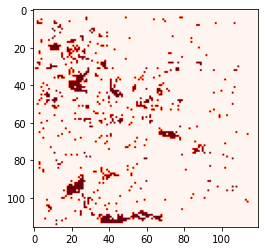

In [9]:
src = rasterio.open('hazard_map.tif')
plt.imshow(src.read(1), cmap='Reds')